In [1]:
from operator import le
import os
from textwrap import wrap
import numpy as np
import math

from scipy.sparse.linalg.dsolve.linsolve import use_solver
from preprocessing import *
import matplotlib.pyplot as plt
import pandas as pd
from utils import *
from copy import copy
from ekf_functions import *

# ICRA Imports
from adaptive_constraint_bound import *
from uwb_baseline_estimate import *
from barrier_function import *

In [2]:
cwd = os.getcwd()
dir_path = cwd[:-3]

###################### SETUP ######################
#- params -------------------------------------------
# 08/26/2021 Trajectory
# date = np.datetime64("2021-08-26")  # measurement date in YYYY-MM-DD
# truth_frequency = 4                 # ground truth frequency 
# obs_freq = 2                        # uwb / observation frequency

# # simulated line trajectory (02/06/2020)
date = np.datetime64("2020-02-06") 
truth_frequency = 10
obs_freq = 10

ksnr = 200
phase_ratio = 300 	                # sigma phase = sigma code / phase_ratio
f = 1575.42 * 10 ** 6
c = 299792458
lda = c / f

# - observation and grouth truth files ------------------
# name_obs1 = dir_path + 'data/20210826_data_icra/leader2.21O'
# name_obs2 = dir_path + 'data/20210826_data_icra/follower.21O' 
# name_eph =  dir_path + 'data/20210826_data_icra/leader2.21N'
# ground_truth = np.loadtxt(dir_path + 'data/20210826_data_icra/Ground_Truth_Static.csv', delimiter = ",")  # ENU
# uwb_data = np.loadtxt(dir_path + 'data/20210826_data_icra/UWB_Baseline_Static.csv', delimiter = ",")      # [range, relative angle, follower heading]

# # - simulated data ------------------------------------
name_obs1 = dir_path + 'data/Line_Revised/Line1/line1.21O'
name_obs2 = dir_path + 'data/Line_Revised/Line2/line2.21O' 
name_eph =  dir_path + 'data/Line_Revised/Line1/line1.21N'
leader = np.loadtxt(dir_path + 'data/Line_Revised/Line1/line1.csv', delimiter = ",")  # ENU
follow = np.loadtxt(dir_path + 'data/Line_Revised/Line2/line2.csv', delimiter = ",") 

# for simulated trajectory, construct the relative ground truth
# print(len(leader), len(follow))
ground_truth = np.zeros_like(leader)
for t in range(len(leader)):
    ground_truth[t, 0] = leader[t, 0]
    ground_truth[t, 1:] = leader[t, 1:] - follow[t, 1:]
# print(ground_truth)


In [3]:
#- preprocess-------------------------------------------
traj1, traj2, eph = loadTrajectories(name_obs1, name_obs2, name_eph)
print('trajectories loaded')

t_gps, svs, code1, code2, carrier1, carrier2, cnos, ts = constructMeasurements(traj1, traj2, date, sort_cn0 = False)
cnos = np.array(cnos)
print('measurements constructed')

gt_vels = []
for i in range(len(ground_truth) - 1):
    instvel = (ground_truth[i + 1, 1:3] - ground_truth[i, 1:3]) / (ground_truth[i + 1, 0] - ground_truth[i, 0])
    gt_vels.append(instvel)
gt_vels = np.array(gt_vels)
print('computed ground truth velocities')

#- for real-world data -------
# gt_inds, obs_inds = match_times(ground_truth, t_gps)     
# dt = ground_truth[gt_inds[1], 0] - ground_truth[gt_inds[0], 0]  
# print('dt', dt)

#- for simulated trajectory ---
dt = 1 / truth_frequency  
gt_inds = np.arange(0, len(ground_truth), 1)
obs_inds = np.arange(0, len(ground_truth), 1)


trajectories loaded
measurements constructed
computed ground truth velocities


<ipython-input-3-3f3ccba161be>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cnos = np.array(cnos)


In [4]:
(leader[1003, 1:] - leader[1002, 1:])/0.1

array([ 8.44942852, -5.34856594,  0.        ])

Text(0.5, 1.0, 'Relative Truth: Line Trajectory')

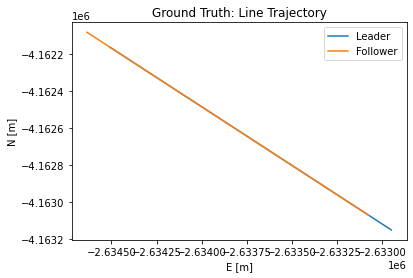

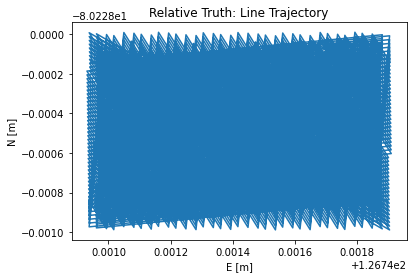

In [5]:
plt.figure()
plt.plot(leader[:, 1], leader[:, 2])
plt.plot(follow[:, 1], follow[:, 2])
plt.xlabel('E [m]')
plt.ylabel('N [m]')
plt.legend(['Leader', 'Follower'])
plt.title('Ground Truth: Line Trajectory')

plt.figure()
plt.plot(ground_truth[:,1], ground_truth[:,2])
plt.xlabel('E [m]')
plt.ylabel('N [m]')
plt.title('Relative Truth: Line Trajectory')

## FUNCTIONS

In [6]:
def init_covariances(k, nState, nMeas, disp=False):

    # State Covariance
    sig_state_e = 3                 # [m]
    sig_state_n = 3                 # [m]
    sig_state_ve = 5                # [m / s]
    sig_state_vn = 5                # [m / s]
    sig_state_int = 50              # [m] number of cycles # CONVERGED

    P = np.zeros((nState, nState))
    P[0, 0] = sig_state_e ** 2
    P[1, 1] = sig_state_n ** 2
    P[2, 2] = sig_state_ve ** 2
    P[3, 3] = sig_state_vn ** 2
    P[4:, 4:] = sig_state_int ** 2 * np.eye(k)
    
    # Dynamics Process Noise
    sig_east = 2                  # [m]
    sig_north = 2                 # [m]
    sig_vel_e = 10                # [m / s]
    sig_vel_n = 10
    sig_intamb = 2

    Q = np.zeros((nState, nState))
    Q[0, 0] = sig_east ** 2
    Q[1, 1] = sig_north ** 2
    Q[2, 2] = sig_vel_e ** 2
    Q[3, 3] = sig_vel_n ** 2
    Q[4:, 4:] = sig_intamb ** 2 * np.eye(k)

    # Measurement Noise
    sig_uwb = 1                    # [m]
    sig_gps_phi = 0.01             # [m]
    sig_gps_rho = 10               # [m]
     
    R = np.zeros((nMeas, nMeas))
    R[0:k, 0:k] = sig_gps_phi ** 2 * np.eye(k)
    R[k:2*k, k:2*k] = sig_gps_rho ** 2 * np.eye(k)
    R[2*k:, 2*k:] = sig_uwb ** 2 * np.eye(nMeas - 2*k)
    R_gps = R[0:2*k, 0:2*k]

    if disp:
        print('P: sig E [{sige}], sig N [{sign}], sig VE [{sigve}], sig VN [{sigvn}], sig Int [{sigint}]'.format(sige=sig_state_e, sign=sig_state_n, sigve=sig_state_ve, sigvn=sig_state_vn, sigint=sig_state_int))
        print('Q: sig E [{sige}], sig N [{sign}], sig VE [{sigve}], sig VN [{sigvn}], sig Int [{sigint}]'.format(sige=sig_east, sign=sig_north, sigve=sig_vel_e, sigvn=sig_vel_n, sigint=sig_intamb))
        print('R: sig UWB [{uwb}], sig Phi [{phi}], sig Rho [{rho}]'.format(uwb=sig_uwb, phi=sig_gps_phi, rho=sig_gps_rho))

    return P, Q, R, R_gps, sig_uwb

## MAIN LOOP

In [7]:
# np.random.seed(0)
# seg_svs = []

# ################ INIT FILTER ###########################
# # seg_start_ind = 0
# # seg_end_ind = 29
# # seg_start_ind = 82
# # seg_end_ind = 111
# # seg_start_ind = 1
# # seg_end_ind = 14
# # seg_start_ind = 123
# # seg_end_ind = 144

# # common_svs = ['G08', 'G10', 'G23', 'G27', 'G32']           # for segment 0 - 29
# # common_svs = ['G08', 'G10', 'G23', 'G27', 'G32']           # for segment 82 - 111
# # common_svs = ['G08', 'G10', 'G21', 'G23', 'G27', 'G32']   # for segment 1 - 14

# # Line Trajectory
# seg_start_ind = 297
# seg_end_ind = 2464
# common_svs = ['G01', 'G03', 'G08', 'G10', 'G11', 'G14', 'G17', 'G18', 'G22', 'G23', 'G25', 'G31', 'G32']
# common_svs = common_svs[0:6]
# ref_ind = np.argmax(cnos[seg_start_ind][0:6])

# print('Common SVS', common_svs)
# print('ref sat', common_svs[ref_ind])
# print('ref CN0', cnos[seg_start_ind][ref_ind])

# K = len(common_svs) - 1     # number of unique DD measurements
# w = 1                       # num of UWB range measurements
# nState = 4 + K              # state vector size
# nMeas = 2 * K + w           # measurement vector size

# P_pre, Q, R, sig_uwb, sig_state_e, sig_state_n, sig_state_ve, sig_state_vn = init_covariances(K, nState, nMeas, disp=True)

# # init_x_e = ground_truth[gt_inds[seg_start_ind], 1]
# # init_x_n = ground_truth[gt_inds[seg_start_ind], 2]
# # init_v_e = gt_vels[gt_inds[seg_start_ind],0]
# # init_v_n = gt_vels[gt_inds[seg_start_ind],1]

# ##### simulated ######
# init_x_e = ground_truth[seg_start_ind, 1]
# init_x_n = ground_truth[seg_start_ind, 2]
# init_v_e = gt_vels[seg_start_ind, 0]
# init_v_n = gt_vels[seg_start_ind, 1]
# #####################

# x_pre = np.zeros((nState, 1))
# x_pre[0] = init_x_e + np.random.normal(0, sig_state_e, 1)
# x_pre[1] = init_x_n + np.random.normal(0, sig_state_n, 1)
# x_pre[2] = init_v_e + np.random.normal(0, sig_state_ve, 1)
# x_pre[3] = init_v_n + np.random.normal(0, sig_state_vn, 1)
# x_pre[4:] = np.ndarray.reshape(get_init_inds(seg_start_ind, common_svs, ref_ind, ksnr, phase_ratio, t_gps, code1, code2, carrier1, carrier2, eph, x0), (K, 1))

# # x_pre[4] = 1 # 1
# # x_pre[5] = -1000 #70
# # x_pre[6] = 100 #100
# # x_pre[7] = -23 #-23

# # LINE TRAJ
# # x_pre[4] = -895.0
# # x_pre[5] = -5879.0
# # x_pre[6] = -978.0
# # x_pre[7] = 228.0
# # x_pre[8] = -1001.0
# # x_pre[9] = -269.0
# # x_pre[10] = -941.0
# # x_pre[11] = -787.0
# # x_pre[12] = -904.0
# # x_pre[13] = -1244.0
# # x_pre[14] = -323.0
# # x_pre[15] = -183.0


# # x_pre[4] = -907       G01
# # x_pre[5] = -5892      G03
# # x_pre[6] = -969       G08
# # x_pre[7] = 223        G10
# # x_pre[8] = -1002      G11
# # x_pre[9] = -269       G14
# # x_pre[10] = -942      G17
# # x_pre[11] = -790      G18
# # x_pre[12] = -916      G22
# # x_pre[13] = -1252     G23
# # x_pre[14] = -328      G25
# # x_pre[15] = -184      G31


# # x_pre[4:] = np.random.randint(-300, 300, (K, 1))

# print('init', np.ndarray.flatten(x_pre))

# x_pre_lambda = copy(x_pre)
# P_pre_lambda = copy(P_pre)

# x_pre_round = copy(x_pre)
# P_pre_round = copy(P_pre)

# x_pre_gps = copy(x_pre)

# ################### MAIN LOOP #############################
# truth = []
# seg_svs = []
# Ps_vals = []

# est = []
# est_lambda = []
# est_round = []

# error = []
# error_lambda = []
# error_round = []

# v_error = []
# v_error_lambda = []
# v_error_round = []

# covars = []
# covars_lambda = []
# covars_round = []

# residuals = []
# residuals_lambda = []
# residuals_round = []

# est.append(np.ndarray.flatten(x_pre))
# covars.append(P_pre)

# est_lambda.append(np.ndarray.flatten(x_pre_lambda))
# covars_lambda.append(P_pre_lambda)

# est_round.append(np.ndarray.flatten(x_pre_round))
# covars_round.append(P_pre_round)


# print('entering loop')

# x0 = np.array([-2.7011e+06,-4.292e+06, 3.8554e+06]) # ECEF coords 
# init_n = None

# ########## ICRA PARAMS ##########
# starting = 1
# T = 20
# alpha, beta = 1.5, 1.5
# p = 1e4
# h = 10
# gt_xy_init = [init_x_e, init_x_n]   # first ground truth x, y coord
# xfixed_all = []
# afixed_icra_all = []
# #####################################

# # for i in range(0, 30):            # ICRA Segment
# for i in range(seg_start_ind, seg_end_ind + 1):
# # for i in range(seg_start_ind, seg_start_ind + 1):
    
#     # get appropriate indices
#     # gt_ind = gt_inds[i]
#     # obs_ind = obs_inds[i]
#     # if ground_truth[gt_ind, 0] != t_gps[obs_ind]:
#         # print('Error: Misaligned timestamps.')
    
#     ### for simulated traj ####
#     gt_ind = i
#     obs_ind = i
#     ###########################
    
#     # GROUND TRUTH
#     truth_term = ground_truth[gt_ind, 1:]
#     truth.append(truth_term[0:2])

#     #- MEASUREMENTS -------------------------------------------------------------------------
#     # gps
#     svs_obs = svs[obs_ind]
#     # seg_svs.append(svs_obs)
#     select_inds = np.where(np.isin(svs_obs, common_svs))
#     select_inds = select_inds[0].tolist()
#     # print(svs_obs, select_inds)

#     select_code1 = [code1[obs_ind][i] for i in select_inds]
#     select_code2 = [code2[obs_ind][i] for i in select_inds]
#     select_carrier1 = [carrier1[obs_ind][i] for i in select_inds]
#     select_carrier2 = [carrier2[obs_ind][i] for i in select_inds]

#     sigma_code, sigma_phase = sigmaFromCN0(cnos[obs_ind], ksnr, phase_ratio)
#     # psi, G, A, sigma = prepareData(t_gps[obs_ind], svs[obs_ind], code1[obs_ind], code2[obs_ind], carrier1[obs_ind], carrier2[obs_ind], eph, plane=False, ref= -1, x0=x0, f=1575.42*10**6, phase_error=0.025)
#     psi, G, A, sigma = prepareData(t_gps[obs_ind], common_svs, np.array(select_code1), np.array(select_code2), np.array(select_carrier1), np.array(select_carrier2), eph, plane=False, ref=ref_ind, x0=x0, f=1575.42*10**6, phase_error=0.025)
#     k = psi.shape[0] // 2               # number of DD measurements in this time step
#     if k != K:
#         print('Error: Satellite number incorrect')
#     H = np.zeros((2 * k, G.shape[1]))
#     H[:k] = G
#     H[k:] = G
#     psi -= truth_term[2] * H[:, 2]
#     H = H[:, :2]

#     # uwb
#     uwb_range = uwb_meas(truth_term[0:2]) + np.random.normal(0, sig_uwb, 1)
#     y = np.reshape(np.append(psi, uwb_range), (2 * k + w, 1))


#     # - FILTERING ----------------------------------------------------------------
#     x_next, P_next, resid = ekf_gnss_uwb(x_pre, P_pre, y, dt, k, w, H, A, Q, R, rescale=False)
#     x_next_lambda, P_next_lambda, resid_lambda = ekf_gnss_uwb(x_pre_lambda, P_pre_lambda, y, dt, k, w, H, A, Q, R, rescale=False)
#     x_next_round, P_next_round, resid_round = ekf_gnss_uwb(x_pre_round, P_pre_round, y, dt, k, w, H, A, Q, R, rescale=False)

#     # LAMBDA
#     # fixed_pos, afixed = lambda_positionFix(np.ndarray.flatten(x_next_lambda[4:] / 0.19), sigma, psi, k, lda, H, A)   # num cycle scaled to [m]
#     fixed_pos, afixed, Ps = lambda_positionFix(np.ndarray.flatten(x_next_lambda[4:]), sigma, psi, k, lda, H, A)
#     # fixed_pos, afixed, Ps = lambda_positionFix(np.ndarray.flatten(x_next_lambda[4:]), sigma, psi, k, lda, H, A, Qahat=P_next_lambda[4:, 4:])
#     # rand_cov = np.random.normal(0, 2, (k, k))
#     # fixed_pos, afixed, Ps = lambda_positionFix(np.ndarray.flatten(x_next_lambda[4:]), sigma, psi, k, lda, H, A, rand_cov.T @ rand_cov)
#     fixed_pos = np.reshape(fixed_pos, (2, 1))
#     x_next_lambda[0:2] = fixed_pos
#     # x_next_lambda[4:] = np.reshape(afixed * 0.19, (K, 1))     # num cycle scaled to [m]
#     x_next_lambda[4:] = np.reshape(afixed, (K, 1))
#     Ps_vals.append(Ps)

#     # Rounding
#     # round_pos, around = round_positionFix(x_next_round[4:] / 0.19, psi, k, lda, H)  # num cycle scaled to [m]
#     round_pos, around = round_positionFix(x_next_round[4:], psi, k, lda, H)   
#     round_pos = np.reshape(round_pos, (2, 1))
#     x_next_round[0:2] = round_pos
#     # x_next_round[4:] = np.reshape(around * 0.19, (K, 1))  # num cycle scaled to [m]
#     x_next_round[4:] = np.reshape(around, (K, 1))


#     #- STORE ----------------------------------------------------------------
#     err = truth_term[0:2] - np.ndarray.flatten(x_next[0:2])
#     v_err = gt_vels[gt_ind] - np.ndarray.flatten(x_next[2:4])

#     err_lambda = truth_term[0:2] - np.ndarray.flatten(x_next_lambda[0:2])
#     v_err_lambda = gt_vels[gt_ind] - np.ndarray.flatten(x_next_lambda[2:4])

#     err_round = truth_term[0:2] - np.ndarray.flatten(x_next_round[0:2])
#     v_err_round = gt_vels[gt_ind] - np.ndarray.flatten(x_next_round[2:4])

#     est.append(np.ndarray.flatten(x_next))
#     covars.append(P_next)
#     error.append(err)
#     v_error.append(v_err)
#     residuals.append(np.ndarray.flatten(resid))

#     x_pre = copy(x_next)
#     P_pre = copy(P_next)

#     est_lambda.append(np.ndarray.flatten(x_next_lambda))
#     covars_lambda.append(P_next_lambda)
#     error_lambda.append(err_lambda)
#     v_error_lambda.append(v_err_lambda)
#     residuals_lambda.append(np.ndarray.flatten(resid_lambda))

#     x_pre_lambda = copy(x_next_lambda)
#     P_pre_lambda = copy(P_next_lambda)

#     est_round.append(np.ndarray.flatten(x_next_round))
#     covars_round.append(P_next_round)
#     error_round.append(err_round)
#     v_error_round.append(v_err_round)
#     residuals_round.append(np.ndarray.flatten(resid_round))
    
#     x_pre_round = copy(x_next_round)
#     P_pre_round = copy(P_next_round)




#     # #- ICRA CODES -----------------------------------------------------------
#     # if starting:
#     #     ptilda_AB, constraint_bounds = baseline_from_uwb(uwb_data[gt_ind, :])
#     #     # ptilda_AB, constraint_bounds = baseline_from_uwb([uwb_range, uwb_ang, 0])
#     #     starting = 0
#     # else:
#     #     ptilda_AB, _ = baseline_from_uwb(uwb_data[gt_ind, :])
#     #     # ptilda_AB, _ = baseline_from_uwb([uwb_range, uwb_ang, 0])

#     # # coordinates
#     # x1 = (ptilda_AB[0] * math.sin(ptilda_AB[1])) 
#     # y1 = (ptilda_AB[0] * math.cos(ptilda_AB[1]))

#     # N = unconstrained_optimization(psi, H, A, sigma, constraint_bounds, p, h, ptilda_AB, gt_xy_init, init_n)
#     # afixed_icra = np.round(N[2:])
#     # a_icra = psi[:k]
#     # b_icra = lda * afixed_icra
#     # x_fixed_icra = a_icra - b_icra
#     # x_fixed_icra = np.dot(np.linalg.pinv(H[:k]), x_fixed_icra)
#     # constraint_bounds = adaptive_constraint_bound(constraint_bounds, T, alpha, beta, ptilda_AB, x_fixed_icra)

#     # xfixed_all.append(x_fixed_icra[:2].copy())
#     # afixed_icra_all.append(afixed_icra)

# print ('code done')


# # ################### PLOTTING ####################
# truth = np.array(truth)
# Ps_vals = np.array(Ps_vals)

# est = np.array(est)
# est_ints = np.array(est[:, 4:])
# error = np.array(error)
# v_error = np.array(v_error)
# covars = np.array(covars)
# residuals = np.array(residuals)

# est_lambda = np.array(est_lambda)
# est_lambda_ints = np.array(est_lambda[:, 4:])
# error_lambda = np.array(error_lambda)
# v_error_lambda = np.array(v_error_lambda)
# covars_lambda = np.array(covars_lambda)
# residuals_lambda = np.array(residuals_lambda)

# est_round = np.array(est_round)
# error_round = np.array(error_round)
# v_error_round = np.array(v_error_round)
# covars_round = np.array(covars_round)
# residuals_round = np.array(residuals_round)

# afixed_icra_all = np.array(afixed_icra_all)
# xfixed_all = np.array(xfixed_all)

# df = pd.DataFrame(est)
# df.to_csv(cwd + '/output/est.csv')

# df = pd.DataFrame(est_ints)
# df.to_csv(cwd + '/output/est_ints.csv')


# df = pd.DataFrame(residuals)
# df.to_csv(cwd + '/output/est_resids.csv')

# df = pd.DataFrame(est_lambda)
# df.to_csv(cwd + '/output/est_lambda.csv')

# df = pd.DataFrame(est_lambda_ints)
# df.to_csv(cwd + '/output/est_lambda_ints.csv')

# df = pd.DataFrame(residuals_lambda)
# df.to_csv(cwd + '/output/est_lambda_resids.csv')

# df = pd.DataFrame(est_round)
# df.to_csv(cwd + '/output/est_round.csv')

# df = pd.DataFrame(Ps_vals)
# df.to_csv(cwd + '/output/Ps.csv')

# # df = pd.DataFrame(afixed_icra_all)
# # df.to_csv('\output\icraInts.csv')

# # df = pd.DataFrame(np.array(seg_svs, dtype=list))
# # df.to_csv('svIDs_Line.csv')

# start_plot_ind = 15


# print('\n')
# print('Err E. Avg: Base', np.mean(error[start_plot_ind:, 0]))
# print('Err E. Max: Base', max(error[start_plot_ind:, 0]))
# print('Err N. Avg: Base', np.mean(error[start_plot_ind:, 1]))
# print('Err N. Max: Base', max(error[start_plot_ind:, 1]))

# print('Err E. Avg: Lambda', np.mean(error_lambda[start_plot_ind:, 0]))
# print('Err E. Max: Lambda', max(error_lambda[start_plot_ind:, 0]))
# print('Err N. Avg: Lambda', np.mean(error_lambda[start_plot_ind:, 1]))
# print('Err N. Max: Lambda', max(error_lambda[start_plot_ind:, 1]))

# print('Err E. Avg: Round', np.mean(error_round[start_plot_ind:, 0]))
# print('Err E. Max: Round', max(error_round[start_plot_ind:, 0]))
# print('Err N. Avg: Round', np.mean(error_round[start_plot_ind:, 1]))
# print('Err N. Max: Round', max(error_round[start_plot_ind:, 1]))

# # print('Err E. Avg: ICRA', np.mean(truth[:, 0] - xfixed_all[:, 0]))
# # print('Err N. Avg: ICRA', np.mean(truth[:, 1] - xfixed_all[:, 1]))
# print('\n')

# # plt.figure()
# # plt.plot(truth[:, 0], truth[:, 1])

# # position coord plots
# plt.figure()
# plt.title('GT vs. Est')
# plt.plot(est[start_plot_ind:, 0], est[start_plot_ind:, 1])
# plt.plot(est_lambda[start_plot_ind:, 0], est_lambda[start_plot_ind:, 1])
# plt.plot(est_round[start_plot_ind:, 0], est_round[start_plot_ind:, 1])
# plt.plot(truth[start_plot_ind:, 0], truth[start_plot_ind:, 1])
# # plt.plot(xfixed_all[:, 0], xfixed_all[:, 1])
# plt.xlabel('East')
# plt.ylabel('North')
# # plt.legend(['Truth', 'Est.', 'Est. LAMBDA', 'Est. Round', 'ICRA'])
# plt.legend(['Base', 'Est. LAMBDA', 'Est. Round', 'Truth'])

# plt.figure()
# plt.title('East')
# plt.plot(truth[start_plot_ind:, 0])
# plt.plot(est[start_plot_ind:, 0])
# plt.plot(est_lambda[start_plot_ind:, 0])
# plt.plot(est_round[start_plot_ind:, 0])
# plt.legend(['Truth', 'Est.', 'Est. LAMBDA', 'Est. Round', 'ICRA'])
# # plt.plot(xfixed_all[:, 0])

# plt.figure()
# plt.title('North')
# plt.plot(truth[start_plot_ind:, 1])
# plt.plot(est[start_plot_ind:, 1])
# plt.plot(est_lambda[start_plot_ind:, 1])
# plt.plot(est_round[start_plot_ind:, 1])
# plt.legend(['Truth', 'Est.', 'Est. LAMBDA', 'Est. Round', 'ICRA'])
# # plt.plot(xfixed_all[:, 1])



# # position error plot
# plt.figure()
# fig_err, ax_err = plt.subplots(2, 1)
# for i in range(2):
#     ax_err[i].plot(error[start_plot_ind:, i])
#     ax_err[i].plot(error_lambda[start_plot_ind:, i])
#     ax_err[i].plot(error_round[start_plot_ind:, i])
#     ax_err[i].legend(['base', 'LAMBDA', 'Round'])
# ax_err[0].set_title('Position Error')
# ax_err[1].set_xlabel('time')
# ax_err[0].set_ylabel('error east [m]')
# ax_err[1].set_ylabel('error north [m]')

# # velocity error plot
# plt.figure()
# fig_v_err, ax_v_err = plt.subplots(2, 1)
# for i in range(2):
#     ax_v_err[i].plot(v_error[start_plot_ind:, i])
#     ax_v_err[i].plot(v_error_lambda[start_plot_ind:, i])
#     ax_v_err[i].plot(v_error_round[start_plot_ind:, i])
#     ax_v_err[i].legend(['base', 'LAMBDA', 'Round'])
# ax_v_err[0].set_title('Velocity Error')
# ax_v_err[1].set_xlabel('time')
# ax_v_err[0].set_ylabel('error V East [m / s]')
# ax_v_err[1].set_ylabel('error V North [m / s]')

# # interger ambiguities
# plt.figure()
# # fig_ints, ax_ints = plt.subplots(K, 1)
# for i in range(K):
#     plt.figure()
#     plt.plot(est[start_plot_ind:, i + 4])
#     plt.plot(est_lambda[start_plot_ind:, i + 4])
#     plt.title('Integers')
#     plt.legend(['Base', 'LAMBDA'])
#     # ax_ints[i].plot(est[start_plot_ind:, i + 4])
#     # ax_ints[i].plot(est_lambda[start_plot_ind:, i + 4])
#     # ax_ints[i].plot(est_round[start_plot_ind:, i + 4])
#     # # ax_ints[i].plot(afixed_icra_all[:, i])
#     # ax_ints[i].set_ylabel('$N_{int}$'.format(int=i))
#     # ax_ints[i].legend(['Base', 'LAMBDA', 'Round', 'ICRA'])
# # ax_ints[0].set_title('Estimated Int Amb.')
# # ax_ints[-1].set_xlabel('time')

# # # measurement residuals
# # plt.figure()
# # fig_resids, ax_resids = plt.subplots(nMeas, 1)
# # for i in range(nMeas):
# #     ax_resids[i].plot(residuals[start_plot_ind:, i])
# #     ax_resids[i].plot(residuals_lambda[start_plot_ind:, i])
# #     ax_resids[i].plot(residuals_round[start_plot_ind:, i])
# #     ax_resids[i].legend(['Base', 'LAMBDA', 'Round'])
# # ax_resids[0].set_title('Measurement Residuals')
# # ax_resids[-1].set_xlabel('time')

# # # for i in range(nMeas):
# # #     print('avg. meas resid', np.mean(residuals[:, i]))


# # Position covariances
# plt.figure()
# plt.title('Covariance East and North')
# plt.plot(covars[:, 0, 0])
# plt.plot(covars[:, 1, 1])
# plt.plot(covars_lambda[:, 0, 0])
# plt.plot(covars_lambda[:, 1, 1])
# plt.xlabel('Time')
# plt.ylabel('$\sigma^{2}$')
# plt.legend(['Base E', 'Base N', 'LAMB E', 'LAMB N'])

# # Velocity covariances
# plt.figure()
# plt.title('Covariance Velocity')
# plt.plot(covars[:,2,2])
# plt.plot(covars[:,3,3])
# plt.plot(covars_lambda[:,2,2])
# plt.plot(covars_lambda[:,3,3])
# plt.xlabel('Time')
# plt.ylabel('$\sigma^{2}$')
# plt.legend(['Base $v_{e}$', 'Base $v_{n}$', 'Lamb $v_{e}$', 'Lamb $v_{n}$'])

# # integer ambiguities covariances
# plt.figure()
# fig_covSat, ax_covSat = plt.subplots(K, 1)
# for i in range(K):
#     ax_covSat[i].plot(covars[:, i + 4, i + 4])
#     ax_covSat[i].set_ylabel('$\sigma^{2}$')
# ax_covSat[0].set_title('Covariance Int Amb.')
# ax_covSat[-1].set_xlabel('time')



# GPS / UWB Comparison

In [8]:
# # np.random.seed(0)

# ################ INIT FILTER ###########################
# # x0 = np.array([-2.7011e+06,-4.292e+06, 3.8554e+06]) # ECEF coords
# x0 = np.array([-2634636.331,-4162082.247,4038273.585])

# # seg_start_ind = 0
# # seg_end_ind = 29
# # seg_start_ind = 82
# # seg_end_ind = 111
# # seg_start_ind = 1
# # seg_end_ind = 14
# # seg_start_ind = 123
# # seg_end_ind = 144

# # common_svs = ['G08', 'G10', 'G23', 'G27', 'G32']           # for segment 0 - 29
# # common_svs = ['G08', 'G10', 'G23', 'G27', 'G32']           # for segment 82 - 111
# # common_svs = ['G08', 'G10', 'G21', 'G23', 'G27', 'G32']   # for segment 1 - 14

# # Line Trajectory
# seg_start_ind = 297
# seg_end_ind = 2464
# common_svs = ['G01', 'G03', 'G08', 'G10', 'G11', 'G14', 'G17', 'G18', 'G22', 'G23', 'G25', 'G31', 'G32']
# # common_svs = ['G01', 'G03', 'G08', 'G10', 'G11', 'G14', 'G17', 'G18', 'G22', 'G23', 'G25', 'G31']
# # common_svs = ['G01', 'G03', 'G08', 'G10', 'G11', 'G14', 'G17', 'G18', 'G22', 'G23', 'G25']
# # common_svs = ['G01', 'G03', 'G08', 'G10', 'G11', 'G14', 'G17', 'G18', 'G22', 'G23']
# # common_svs = ['G01', 'G03', 'G08', 'G10', 'G11', 'G14', 'G17', 'G18', 'G22']
# # common_svs = ['G01', 'G03', 'G08', 'G10', 'G11', 'G14', 'G17', 'G18']
# # common_svs = ['G01', 'G03', 'G08', 'G10', 'G11', 'G14', 'G17']
# # common_svs = ['G01', 'G03', 'G08', 'G10', 'G11', 'G14']
# # common_svs = ['G01', 'G03', 'G08', 'G10', 'G11',]
# # common_svs = ['G01', 'G03', 'G08', 'G10']
# # common_svs = ['G01', 'G03', 'G08']


# # ref_ind = np.argmax(cnos[seg_start_ind][0:])
# ref_ind = 9

# print('Common SVS', common_svs)
# print('ref sat', common_svs[ref_ind])
# print('ref CN0', cnos[seg_start_ind][ref_ind])

# K = len(common_svs) - 1     # number of unique DD measurements
# w = 1                       # num of UWB range measurements
# nState = 4 + K              # state vector size
# nMeas = 2 * K + w           # measurement vector size

# P_pre, Q, R, R_gps, sig_uwb = init_covariances(K, nState, nMeas, disp=True)

# # init_x_e = ground_truth[gt_inds[seg_start_ind], 1]
# # init_x_n = ground_truth[gt_inds[seg_start_ind], 2]
# # init_v_e = gt_vels[gt_inds[seg_start_ind],0]
# # init_v_n = gt_vels[gt_inds[seg_start_ind],1]

# ##### simulated ######
# init_x_e = ground_truth[seg_start_ind, 1]
# init_x_n = ground_truth[seg_start_ind, 2]
# init_v_e = gt_vels[seg_start_ind, 0]
# init_v_n = gt_vels[seg_start_ind, 1]
# #####################

# x_pre = np.zeros((nState, 1))
# x_pre[0] = init_x_e + np.random.normal(0, math.sqrt(P_pre[0, 0]), 1)
# x_pre[1] = init_x_n + np.random.normal(0, math.sqrt(P_pre[1, 1]), 1)
# x_pre[2] = init_v_e + np.random.normal(0, math.sqrt(P_pre[2, 2]), 1)
# x_pre[3] = init_v_n + np.random.normal(0, math.sqrt(P_pre[3, 3]), 1)
# x_pre[4:] = np.ndarray.reshape(get_init_inds(ground_truth, seg_start_ind, ground_truth[seg_start_ind], svs, common_svs, gt_inds, obs_inds, ref_ind, K, t_gps, code1, code2, carrier1, carrier2, eph, x0), (K, 1))
# # print('init', np.ndarray.flatten(x_pre))

# x_pre_lambda = copy(x_pre)
# P_pre_lambda = copy(P_pre)

# x_pre_round = copy(x_pre)
# P_pre_round = copy(P_pre)

# x_pre_gps = copy(x_pre)
# P_pre_gps = copy(P_pre)

# ################### MAIN LOOP #############################
# truth = []
# seg_svs = []

# est_round = []
# covars_round = []
# residuals_round = []
# error_round = []
# v_error_round = []
# est_round.append(np.ndarray.flatten(x_pre_round))
# covars_round.append(P_pre_round)


# est_lambda = []
# covars_lambda = []
# residuals_lambda = []
# Ps_vals = []
# error_lambda = []
# v_error_lambda = []
# est_lambda.append(np.ndarray.flatten(x_pre_lambda))
# covars_lambda.append(P_pre_lambda)


# est_gps = []
# covars_gps = []
# residuals_gps = []
# Ps_vals_gps = []
# error_gps = []
# v_error_gps = []
# est_gps.append(np.ndarray.flatten(x_pre_gps))
# covars_gps.append(P_pre_gps)


# print('entering loop')
# init_n = None

# for i in range(seg_start_ind, seg_end_ind + 1):
    
#     # get appropriate indices
#     # gt_ind = gt_inds[i]
#     # obs_ind = obs_inds[i]
#     # if ground_truth[gt_ind, 0] != t_gps[obs_ind]:
#     #     print('Error: Misaligned timestamps.')
    
#     ### for simulated traj ####
#     gt_ind = i
#     obs_ind = i
#     ###########################
    
#     # GROUND TRUTH
#     truth_term = ground_truth[gt_ind, 1:]
#     truth.append(truth_term[0:2])

#     #- MEASUREMENTS -------------------------------------------------------------------------
#     # gps
#     svs_obs = svs[obs_ind]
#     select_inds = np.where(np.isin(svs_obs, common_svs))
#     select_inds = select_inds[0].tolist()

#     select_code1 = [code1[obs_ind][i] for i in select_inds]
#     select_code2 = [code2[obs_ind][i] for i in select_inds]
#     select_carrier1 = [carrier1[obs_ind][i] for i in select_inds]
#     select_carrier2 = [carrier2[obs_ind][i] for i in select_inds]
#     select_cnos = [cnos[obs_ind][i] for i in select_inds]

#     sigma_code, sigma_phase = sigmaFromCN0(select_cnos, ksnr, phase_ratio)
#     psi, G, A, sigma = prepareData(t_gps[obs_ind], common_svs, np.array(select_code1), np.array(select_code2), np.array(select_carrier1), np.array(select_carrier2), eph, plane=False, ref=ref_ind, x0=x0, f=1575.42*10**6, phase_error=0.025)
#     k = psi.shape[0] // 2               # number of DD measurements in this time step
#     if k != K:
#         print('Error: Satellite number incorrect')
#     H = np.zeros((2 * k, G.shape[1]))
#     H[:k] = G
#     H[k:] = G
#     psi -= truth_term[2] * H[:, 2]
#     H = H[:, :2]

#     # uwb
#     uwb_range = uwb_meas(truth_term[0:2]) + np.random.normal(0, sig_uwb, 1)
#     # uwb_range = uwb_data[gt_ind, 0]

#     # construct meas vec
#     y = np.reshape(np.append(psi, uwb_range), (2 * k + w, 1))
#     y_gps = np.reshape(psi, (2 * k, 1))


#     # - FILTERING ----------------------------------------------------------------
#     x_next_lambda, P_next_lambda, resid_lambda = ekf_gnss_uwb(x_pre_lambda, P_pre_lambda, y, dt, k, w, H, A, Q, R)
#     x_next_round, P_next_round, resid_round = ekf_gnss_uwb(x_pre_round, P_pre_round, y, dt, k, w, H, A, Q, R)
#     x_next_gps, P_next_gps, resid_gps = ekf_gnss(x_pre_gps, P_pre_gps, y_gps, dt, k, H, A, Q, R_gps)

#     # LAMBDA
#     fixed_pos, afixed, Ps = lambda_positionFix(np.ndarray.flatten(x_next_lambda[4:]), sigma, psi, k, lda, H, A)
#     fixed_pos = np.reshape(fixed_pos, (2, 1))
#     x_next_lambda[0:2] = fixed_pos
#     x_next_lambda[4:] = np.reshape(afixed, (K, 1))
#     Ps_vals.append(Ps)

#     # Rounding
#     round_pos, around = round_positionFix(x_next_round[4:], psi, k, lda, H)   
#     round_pos = np.reshape(round_pos, (2, 1))
#     x_next_round[0:2] = round_pos
#     x_next_round[4:] = np.reshape(around, (K, 1))

#     # GPS Only
#     fixed_pos_gps, afixed_gps, Ps_gps = lambda_positionFix(np.ndarray.flatten(x_next_gps[4:]), sigma, psi, k, lda, H, A)
#     fixed_pos_gps = np.reshape(fixed_pos_gps, (2, 1))
#     x_next_gps[0:2] = fixed_pos_gps
#     x_next_gps[4:] = np.reshape(afixed_gps, (K,1))
#     Ps_vals_gps.append(Ps_gps)

#     #- STORE ----------------------------------------------------------------
#     err_lambda = truth_term[0:2] - np.ndarray.flatten(x_next_lambda[0:2])
#     v_err_lambda = gt_vels[gt_ind] - np.ndarray.flatten(x_next_lambda[2:4])

#     err_round = truth_term[0:2] - np.ndarray.flatten(x_next_round[0:2])
#     v_err_round = gt_vels[gt_ind] - np.ndarray.flatten(x_next_round[2:4])

#     err_gps = truth_term[0:2] - np.ndarray.flatten(x_next_gps[0:2])
#     v_err_gps = gt_vels[gt_ind] - np.ndarray.flatten(x_next_gps[2:4])

 
#     est_lambda.append(np.ndarray.flatten(x_next_lambda))
#     covars_lambda.append(P_next_lambda)
#     error_lambda.append(err_lambda)
#     v_error_lambda.append(v_err_lambda)
#     residuals_lambda.append(np.ndarray.flatten(resid_lambda))

#     x_pre_lambda = copy(x_next_lambda)
#     P_pre_lambda = copy(P_next_lambda)

#     est_round.append(np.ndarray.flatten(x_next_round))
#     covars_round.append(P_next_round)
#     error_round.append(err_round)
#     v_error_round.append(v_err_round)
#     residuals_round.append(np.ndarray.flatten(resid_round))
    
#     x_pre_round = copy(x_next_round)
#     P_pre_round = copy(P_next_round)

#     est_gps.append(np.ndarray.flatten(x_next_gps))
#     covars_gps.append(P_next_gps)
#     error_gps.append(err_gps) 
#     v_error_gps.append(v_err_gps)
#     residuals_gps.append(np.ndarray.flatten(resid_gps))

#     x_pre_gps = copy(x_next_gps)
#     P_pre_gps = copy(P_next_gps)

# print ('code done')


# # ################### PLOTTING ####################
# truth = np.array(truth)
# Ps_vals = np.array(Ps_vals)
# Ps_vals_gps = np.array(Ps_vals_gps)

# est_lambda = np.array(est_lambda)
# est_lambda_ints = np.array(est_lambda[:, 4:])
# error_lambda = np.array(error_lambda)
# v_error_lambda = np.array(v_error_lambda)
# covars_lambda = np.array(covars_lambda)
# residuals_lambda = np.array(residuals_lambda)

# est_round = np.array(est_round)
# error_round = np.array(error_round)
# v_error_round = np.array(v_error_round)
# covars_round = np.array(covars_round)
# residuals_round = np.array(residuals_round)

# est_gps = np.array(est_gps)
# est_gps_ints = np.array(est_gps[:, 4:])
# error_gps = np.array(error_gps)
# v_error_gps = np.array(v_error_gps)
# covars_gps = np.array(covars_gps)
# residuals_gps = np.array(residuals_gps)


# df = pd.DataFrame(est_lambda)
# df.to_csv(cwd + '/output/est_lambda.csv')

# df = pd.DataFrame(est_lambda_ints)
# df.to_csv(cwd + '/output/est_lambda_ints.csv')

# df_rlamb = pd.DataFrame(residuals_lambda)
# df_rlamb.to_csv(cwd + '/output/est_lambda_resids.csv')

# df = pd.DataFrame(est_gps_ints)
# df.to_csv(cwd + '/output/est_gps_ints.csv')

# df_rgps = pd.DataFrame(residuals_gps)
# df_rgps.to_csv(cwd + '/output/residuals_gps.csv')

# df = pd.DataFrame(est_round)
# df.to_csv(cwd + '/output/est_round.csv')

# df = pd.DataFrame(Ps_vals)
# df.to_csv(cwd + '/output/Ps.csv')

# df = pd.DataFrame(Ps_vals_gps)
# df.to_csv(cwd + '/output/Ps_gps.csv')

# df_rround = pd.DataFrame(residuals_round)
# df_rround.to_csv(cwd + '/output/residuals_rounding.csv')

# start_plot_ind = 15


# print('\n')

# print('Err E. Avg: Lambda', np.mean(error_lambda[start_plot_ind:, 0]))
# print('Err E. Max: Lambda', max(abs(error_lambda[start_plot_ind:, 0])))
# print('Err N. Avg: Lambda', np.mean(error_lambda[start_plot_ind:, 1]))
# print('Err N. Max: Lambda', max(abs(error_lambda[start_plot_ind:, 1])))

# print('Err E. Avg: Round', np.mean(error_round[start_plot_ind:, 0]))
# print('Err E. Max: Round', max(abs(error_round[start_plot_ind:, 0])))
# print('Err N. Avg: Round', np.mean(error_round[start_plot_ind:, 1]))
# print('Err N. Max: Round', max(abs(error_round[start_plot_ind:, 1])))

# print('Err E. Avg: GPS', np.mean(error_gps[start_plot_ind:, 0]))
# print('Err E. Max: GPS', max(abs(error_gps[start_plot_ind:, 0])))
# print('Err N. Avg: GPS', np.mean(error_gps[start_plot_ind:, 1]))
# print('Err N. Max: GPS', max(abs(error_gps[start_plot_ind:, 1])))

# print('\n')

# # position coord plots
# plt.figure()
# plt.title('GT vs. Est')
# plt.plot(est_round[start_plot_ind:, 0], est_round[start_plot_ind:, 1])
# plt.plot(est_lambda[start_plot_ind:, 0], est_lambda[start_plot_ind:, 1])
# plt.plot(est_gps[start_plot_ind:, 0], est_gps[start_plot_ind:, 1])
# plt.plot(truth[start_plot_ind:, 0], truth[start_plot_ind:, 1], 'k.')
# plt.xlabel('East')
# plt.ylabel('North')
# plt.legend(['G + U + Round', 'G + U + LAMBDA', 'G + LAMBDA', 'Truth'])

# plt.figure()
# plt.title('East')
# plt.plot(est_round[start_plot_ind:, 0])
# plt.plot(est_lambda[start_plot_ind:, 0])
# plt.plot(est_gps[start_plot_ind:, 0])
# plt.plot(truth[start_plot_ind:, 0])
# plt.legend([ 'G + U + Round', 'G + U + LAMBDA', 'G + LAMBDA', 'Truth'])

# plt.figure()
# plt.title('North')
# plt.plot(est_round[start_plot_ind:, 1])
# plt.plot(est_lambda[start_plot_ind:, 1])
# plt.plot(est_gps[start_plot_ind:, 1])
# plt.plot(truth[start_plot_ind:, 1])
# plt.legend(['Round', 'Est. LAMBDA', 'GPS ONlY', 'Truth'])


# # position error plot
# plt.figure()
# fig_err, ax_err = plt.subplots(2, 1)
# for i in range(2):
#     ax_err[i].plot(error_round[start_plot_ind:, i])
#     ax_err[i].plot(error_lambda[start_plot_ind:, i])
#     ax_err[i].plot(error_gps[start_plot_ind:, i])
#     ax_err[i].legend(['G + U + Round', 'G + U + LAMBDA', 'G + LAMBDA'])
# ax_err[0].set_title('Position Error')
# ax_err[1].set_xlabel('time')
# ax_err[0].set_ylabel('error east [m]')
# ax_err[1].set_ylabel('error north [m]')

# # velocity error plot
# plt.figure()
# fig_v_err, ax_v_err = plt.subplots(2, 1)
# for i in range(2):
#     ax_v_err[i].plot(v_error_round[start_plot_ind:, i])
#     ax_v_err[i].plot(v_error_lambda[start_plot_ind:, i])
#     ax_v_err[i].plot(v_error_gps[start_plot_ind:, i])
#     ax_v_err[i].legend(['G + U + Round', 'G + U + LAMBDA', 'G + LAMBDA'])
# ax_v_err[0].set_title('Velocity Error')
# ax_v_err[1].set_xlabel('time')
# ax_v_err[0].set_ylabel('error V East [m / s]')
# ax_v_err[1].set_ylabel('error V North [m / s]')

# # integer ambiguities
# plt.figure()
# for i in range(K):
#     plt.figure()
#     plt.plot(est_round[start_plot_ind:, i + 4])
#     plt.plot(est_lambda[start_plot_ind:, i + 4])
#     plt.plot(est_gps[start_plot_ind:, i + 4])
#     plt.title('Integers')
#     plt.legend(['G + U + Round', 'G + U + LAMBDA', 'G + LAMBDA'])


# # Position covariances
# plt.figure()
# plt.title('Covariance East and North')
# plt.plot(covars_lambda[:, 0, 0])
# plt.plot(covars_lambda[:, 1, 1])
# plt.plot(covars_gps[:, 0, 0])
# plt.plot(covars_gps[:, 1, 1])
# plt.xlabel('Time')
# plt.ylabel('$\sigma^{2}$')
# plt.legend(['LAMB E', 'LAMB N', 'GPS E', 'GPS N'])

# # Velocity covariancesa
# plt.figure()
# plt.title('Covariance Velocity')
# plt.plot(covars_lambda[:,2,2])
# plt.plot(covars_lambda[:,3,3])
# plt.plot(covars_gps[:,2,2])
# plt.plot(covars_gps[:,3,3])
# plt.xlabel('Time')
# plt.ylabel('$\sigma^{2}$')
# plt.legend(['Lamb $v_{e}$', 'Lamb $v_{n}$', 'GPS $v_{e}$', 'GPS $v_{n}$'])

# # integer ambiguities covariances
# plt.figure()
# fig_covSat, ax_covSat = plt.subplots(K, 1)
# for i in range(K):
#     ax_covSat[i].plot(covars_lambda[:, i + 4, i + 4])
#     ax_covSat[i].plot(covars_gps[:, i + 4, i + 4])
#     ax_covSat[i].set_ylabel('$\sigma^{2}$')
# ax_covSat[0].set_title('Covariance Int Amb.')
# ax_covSat[0].legend(['Lambda', 'GPS'])
# ax_covSat[-1].set_xlabel('time')



# For AA272

In [36]:
# np.random.seed(0)

################ INIT FILTER ###########################
x0 = np.array([-2634636.331,-4162082.247,4038273.585])

# Line Trajectory
seg_start_ind = 297
seg_end_ind = 2464
# common_svs = ['G01', 'G03', 'G08', 'G10', 'G11', 'G14', 'G17', 'G18', 'G22', 'G23', 'G25', 'G31', 'G32']
# common_svs = ['G01', 'G03', 'G08', 'G10', 'G11', 'G14', 'G17', 'G18', 'G22', 'G23', 'G25', 'G31']
# common_svs = ['G01', 'G03', 'G08', 'G10', 'G11', 'G14', 'G17', 'G18', 'G22', 'G23', 'G25']
# common_svs = ['G01', 'G03', 'G08', 'G10', 'G11', 'G14', 'G17', 'G18', 'G22', 'G23']
# common_svs = ['G01', 'G03', 'G08', 'G10', 'G11', 'G14', 'G17', 'G18', 'G22']
# common_svs = ['G01', 'G03', 'G08', 'G10', 'G11', 'G14', 'G17', 'G18']
# common_svs = ['G01', 'G03', 'G08', 'G10', 'G11', 'G14', 'G17']
# common_svs = ['G01', 'G03', 'G08', 'G10', 'G11', 'G14']
# common_svs = ['G01', 'G03', 'G08', 'G10', 'G11']
common_svs = ['G01', 'G03', 'G08', 'G10']


# ref_ind = np.argmax(cnos[seg_start_ind][0:])
ref_ind = 1

print('Common SVS', common_svs)
print('ref sat', common_svs[ref_ind])
print('ref CN0', cnos[seg_start_ind][ref_ind])

K = len(common_svs) - 1     # number of unique DD measurements
w = 1                       # num of UWB range measurements
nState = 4 + K              # state vector size
nMeas = 2 * K + w           # measurement vector size

P_pre, Q, R, R_gps, sig_uwb = init_covariances(K, nState, nMeas, disp=True)

init_x_e = ground_truth[seg_start_ind, 1]
init_x_n = ground_truth[seg_start_ind, 2]
init_v_e = gt_vels[seg_start_ind, 0]
init_v_n = gt_vels[seg_start_ind, 1]

x_pre = np.zeros((nState, 1))
x_pre[0] = init_x_e + np.random.normal(0, math.sqrt(P_pre[0, 0]), 1)
x_pre[1] = init_x_n + np.random.normal(0, math.sqrt(P_pre[1, 1]), 1)
x_pre[2] = init_v_e + np.random.normal(0, math.sqrt(P_pre[2, 2]), 1)
x_pre[3] = init_v_n + np.random.normal(0, math.sqrt(P_pre[3, 3]), 1)
x_pre[4:] = np.ndarray.reshape(get_init_inds(ground_truth, seg_start_ind, ground_truth[seg_start_ind], svs, common_svs, gt_inds, obs_inds, ref_ind, K, t_gps, code1, code2, carrier1, carrier2, eph, x0), (K, 1))

x_pre_lambda = copy(x_pre)
P_pre_lambda = copy(P_pre)

x_pre_round = copy(x_pre)
P_pre_round = copy(P_pre)

x_pre_gps = copy(x_pre)
P_pre_gps = copy(P_pre)

################### MAIN LOOP #############################
print('entering loop')
init_n = None
start_plot_ind = 15

err_avg_e_lam = 0
err_max_e_lam = 0
err_avg_n_lam = 0
err_max_n_lam = 0
err_avg_e_rou = 0
err_max_e_rou = 0
err_avg_n_rou = 0
err_max_n_rou = 0
err_avg_e_gps = 0
err_max_e_gps = 0
err_avg_n_gps = 0
err_max_n_gps = 0

for n in range(5):
    truth = []
    seg_svs = []

    est_round = []
    covars_round = []
    residuals_round = []
    error_round = []
    v_error_round = []
    est_round.append(np.ndarray.flatten(x_pre_round))
    covars_round.append(P_pre_round)


    est_lambda = []
    covars_lambda = []
    residuals_lambda = []
    Ps_vals = []
    error_lambda = []
    v_error_lambda = []
    est_lambda.append(np.ndarray.flatten(x_pre_lambda))
    covars_lambda.append(P_pre_lambda)


    est_gps = []
    covars_gps = []
    residuals_gps = []
    Ps_vals_gps = []
    error_gps = []
    v_error_gps = []
    est_gps.append(np.ndarray.flatten(x_pre_gps))
    covars_gps.append(P_pre_gps)

    for i in range(seg_start_ind, seg_end_ind + 1):
        gt_ind = i
        obs_ind = i
    
        # GROUND TRUTH
        truth_term = ground_truth[gt_ind, 1:]
        truth.append(truth_term[0:2])

        #- MEASUREMENTS -------------------------------------------------------------------------
        # gps
        svs_obs = svs[obs_ind]
        select_inds = np.where(np.isin(svs_obs, common_svs))
        select_inds = select_inds[0].tolist()

        select_code1 = [code1[obs_ind][i] for i in select_inds]
        select_code2 = [code2[obs_ind][i] for i in select_inds]
        select_carrier1 = [carrier1[obs_ind][i] for i in select_inds]
        select_carrier2 = [carrier2[obs_ind][i] for i in select_inds]
        select_cnos = [cnos[obs_ind][i] for i in select_inds]

        sigma_code, sigma_phase = sigmaFromCN0(select_cnos, ksnr, phase_ratio)
        psi, G, A, sigma = prepareData(t_gps[obs_ind], common_svs, np.array(select_code1), np.array(select_code2), np.array(select_carrier1), np.array(select_carrier2), eph, plane=False, ref=ref_ind, x0=x0, f=1575.42*10**6, phase_error=0.025)
        k = psi.shape[0] // 2               # number of DD measurements in this time step
        if k != K:
            print('Error: Satellite number incorrect')
        H = np.zeros((2 * k, G.shape[1]))
        H[:k] = G
        H[k:] = G
        psi -= truth_term[2] * H[:, 2]
        H = H[:, :2]

        # uwb
        uwb_range = uwb_meas(truth_term[0:2]) + np.random.normal(0, sig_uwb, 1)

        # construct meas vec
        y = np.reshape(np.append(psi, uwb_range), (2 * k + w, 1))
        y_gps = np.reshape(psi, (2 * k, 1))


        # - FILTERING ----------------------------------------------------------------
        x_next_lambda, P_next_lambda, resid_lambda = ekf_gnss_uwb(x_pre_lambda, P_pre_lambda, y, dt, k, w, H, A, Q, R)
        x_next_round, P_next_round, resid_round = ekf_gnss_uwb(x_pre_round, P_pre_round, y, dt, k, w, H, A, Q, R)
        x_next_gps, P_next_gps, resid_gps = ekf_gnss(x_pre_gps, P_pre_gps, y_gps, dt, k, H, A, Q, R_gps)

        # LAMBDA
        fixed_pos, afixed, Ps = lambda_positionFix(np.ndarray.flatten(x_next_lambda[4:]), sigma, psi, k, lda, H, A)
        fixed_pos = np.reshape(fixed_pos, (2, 1))
        x_next_lambda[0:2] = fixed_pos
        x_next_lambda[4:] = np.reshape(afixed, (K, 1))
        Ps_vals.append(Ps)

        # Rounding
        round_pos, around = round_positionFix(x_next_round[4:], psi, k, lda, H)   
        round_pos = np.reshape(round_pos, (2, 1))
        x_next_round[0:2] = round_pos
        x_next_round[4:] = np.reshape(around, (K, 1))

        # GPS Only
        fixed_pos_gps, afixed_gps, Ps_gps = lambda_positionFix(np.ndarray.flatten(x_next_gps[4:]), sigma, psi, k, lda, H, A)
        fixed_pos_gps = np.reshape(fixed_pos_gps, (2, 1))
        x_next_gps[0:2] = fixed_pos_gps
        x_next_gps[4:] = np.reshape(afixed_gps, (K,1))
        Ps_vals_gps.append(Ps_gps)

        #- STORE ----------------------------------------------------------------
        err_lambda = truth_term[0:2] - np.ndarray.flatten(x_next_lambda[0:2])
        v_err_lambda = gt_vels[gt_ind] - np.ndarray.flatten(x_next_lambda[2:4])

        err_round = truth_term[0:2] - np.ndarray.flatten(x_next_round[0:2])
        v_err_round = gt_vels[gt_ind] - np.ndarray.flatten(x_next_round[2:4])

        err_gps = truth_term[0:2] - np.ndarray.flatten(x_next_gps[0:2])
        v_err_gps = gt_vels[gt_ind] - np.ndarray.flatten(x_next_gps[2:4])


        est_lambda.append(np.ndarray.flatten(x_next_lambda))
        covars_lambda.append(P_next_lambda)
        error_lambda.append(err_lambda)
        v_error_lambda.append(v_err_lambda)
        residuals_lambda.append(np.ndarray.flatten(resid_lambda))

        x_pre_lambda = copy(x_next_lambda)
        P_pre_lambda = copy(P_next_lambda)

        est_round.append(np.ndarray.flatten(x_next_round))
        covars_round.append(P_next_round)
        error_round.append(err_round)
        v_error_round.append(v_err_round)
        residuals_round.append(np.ndarray.flatten(resid_round))

        x_pre_round = copy(x_next_round)
        P_pre_round = copy(P_next_round)

        est_gps.append(np.ndarray.flatten(x_next_gps))
        covars_gps.append(P_next_gps)
        error_gps.append(err_gps) 
        v_error_gps.append(v_err_gps)
        residuals_gps.append(np.ndarray.flatten(resid_gps))

        x_pre_gps = copy(x_next_gps)
        P_pre_gps = copy(P_next_gps)
    
    error_lambda = np.array(error_lambda)
    error_round = np.array(error_round)
    error_gps = np.array(error_gps)

    err_avg_e_lam += np.mean(error_lambda[start_plot_ind:, 0])
    err_max_e_lam += max(abs(error_lambda[start_plot_ind:, 0]))
    err_avg_n_lam += np.mean(error_lambda[start_plot_ind:, 1])
    err_max_n_lam += max(abs(error_lambda[start_plot_ind:, 1]))

    err_avg_e_rou += np.mean(error_round[start_plot_ind:, 0])
    err_max_e_rou += max(abs(error_round[start_plot_ind:, 0]))
    err_avg_n_rou += np.mean(error_round[start_plot_ind:, 1])
    err_max_n_rou += max(abs(error_round[start_plot_ind:, 1]))

    err_avg_e_gps += np.mean(error_gps[start_plot_ind:, 0])
    err_max_e_gps += max(abs(error_gps[start_plot_ind:, 0]))
    err_avg_n_gps += np.mean(error_gps[start_plot_ind:, 1])
    err_max_n_gps += max(abs(error_gps[start_plot_ind:, 1]))

print('Avg. E Lambda: ', err_avg_e_lam / 5)
print('Max. E Lambda: ', err_max_e_lam / 5)
print('Avg. N Lambda: ', err_avg_n_lam / 5)
print('Max. N Lambda: ', err_max_n_lam / 5)

print('Avg. E Round: ', err_avg_e_rou / 5)
print('Max. E Round: ', err_max_e_rou / 5)
print('Avg. N Round: ', err_avg_n_rou / 5)
print('Max. N Round: ', err_max_n_rou / 5)

print('Avg. E GPS: ', err_avg_e_gps / 5)
print('Max. E GPS: ', err_max_e_gps / 5)
print('Avg. N GPS: ', err_avg_n_gps / 5)
print('Max. N GPS: ', err_max_n_gps / 5)

print ('code done')


# ################### PLOTTING ####################
# truth = np.array(truth)
# Ps_vals = np.array(Ps_vals)
# Ps_vals_gps = np.array(Ps_vals_gps)

# est_lambda = np.array(est_lambda)
# est_lambda_ints = np.array(est_lambda[:, 4:])
# error_lambda = np.array(error_lambda)
# v_error_lambda = np.array(v_error_lambda)
# covars_lambda = np.array(covars_lambda)
# residuals_lambda = np.array(residuals_lambda)

# est_round = np.array(est_round)
# error_round = np.array(error_round)
# v_error_round = np.array(v_error_round)
# covars_round = np.array(covars_round)
# residuals_round = np.array(residuals_round)

# est_gps = np.array(est_gps)
# est_gps_ints = np.array(est_gps[:, 4:])
# error_gps = np.array(error_gps)
# v_error_gps = np.array(v_error_gps)
# covars_gps = np.array(covars_gps)
# residuals_gps = np.array(residuals_gps)


# df = pd.DataFrame(est_lambda)
# df.to_csv(cwd + '/output/est_lambda.csv')

# df = pd.DataFrame(est_lambda_ints)
# df.to_csv(cwd + '/output/est_lambda_ints.csv')

# df_rlamb = pd.DataFrame(residuals_lambda)
# df_rlamb.to_csv(cwd + '/output/est_lambda_resids.csv')

# df = pd.DataFrame(est_gps_ints)
# df.to_csv(cwd + '/output/est_gps_ints.csv')

# df_rgps = pd.DataFrame(residuals_gps)
# df_rgps.to_csv(cwd + '/output/residuals_gps.csv')

# df = pd.DataFrame(est_round)
# df.to_csv(cwd + '/output/est_round.csv')

# df = pd.DataFrame(Ps_vals)
# df.to_csv(cwd + '/output/Ps.csv')

# df = pd.DataFrame(Ps_vals_gps)
# df.to_csv(cwd + '/output/Ps_gps.csv')

# df_rround = pd.DataFrame(residuals_round)
# df_rround.to_csv(cwd + '/output/residuals_rounding.csv')



# print('\n')

# print('Err E. Avg: Lambda', np.mean(error_lambda[start_plot_ind:, 0]))
# print('Err E. Max: Lambda', max(abs(error_lambda[start_plot_ind:, 0])))
# print('Err N. Avg: Lambda', np.mean(error_lambda[start_plot_ind:, 1]))
# print('Err N. Max: Lambda', max(abs(error_lambda[start_plot_ind:, 1])))

# print('Err E. Avg: Round', np.mean(error_round[start_plot_ind:, 0]))
# print('Err E. Max: Round', max(abs(error_round[start_plot_ind:, 0])))
# print('Err N. Avg: Round', np.mean(error_round[start_plot_ind:, 1]))
# print('Err N. Max: Round', max(abs(error_round[start_plot_ind:, 1])))

# print('Err E. Avg: GPS', np.mean(error_gps[start_plot_ind:, 0]))
# print('Err E. Max: GPS', max(abs(error_gps[start_plot_ind:, 0])))
# print('Err N. Avg: GPS', np.mean(error_gps[start_plot_ind:, 1]))
# print('Err N. Max: GPS', max(abs(error_gps[start_plot_ind:, 1])))

# print('\n')

# # position coord plots
# plt.figure()
# plt.title('GT vs. Est')
# plt.plot(est_round[start_plot_ind:, 0], est_round[start_plot_ind:, 1])
# plt.plot(est_lambda[start_plot_ind:, 0], est_lambda[start_plot_ind:, 1])
# plt.plot(est_gps[start_plot_ind:, 0], est_gps[start_plot_ind:, 1])
# plt.plot(truth[start_plot_ind:, 0], truth[start_plot_ind:, 1], 'k.')
# plt.xlabel('East')
# plt.ylabel('North')
# plt.legend(['G + U + Round', 'G + U + LAMBDA', 'G + LAMBDA', 'Truth'])

# plt.figure()
# plt.title('East')
# plt.plot(est_round[start_plot_ind:, 0])
# plt.plot(est_lambda[start_plot_ind:, 0])
# plt.plot(est_gps[start_plot_ind:, 0])
# plt.plot(truth[start_plot_ind:, 0])
# plt.legend([ 'G + U + Round', 'G + U + LAMBDA', 'G + LAMBDA', 'Truth'])

# plt.figure()
# plt.title('North')
# plt.plot(est_round[start_plot_ind:, 1])
# plt.plot(est_lambda[start_plot_ind:, 1])
# plt.plot(est_gps[start_plot_ind:, 1])
# plt.plot(truth[start_plot_ind:, 1])
# plt.legend(['Round', 'Est. LAMBDA', 'GPS ONlY', 'Truth'])


# # position error plot
# plt.figure()
# fig_err, ax_err = plt.subplots(2, 1)
# for i in range(2):
#     ax_err[i].plot(error_round[start_plot_ind:, i])
#     ax_err[i].plot(error_lambda[start_plot_ind:, i])
#     ax_err[i].plot(error_gps[start_plot_ind:, i])
#     ax_err[i].legend(['G + U + Round', 'G + U + LAMBDA', 'G + LAMBDA'])
# ax_err[0].set_title('Position Error')
# ax_err[1].set_xlabel('time')
# ax_err[0].set_ylabel('error east [m]')
# ax_err[1].set_ylabel('error north [m]')

# # velocity error plot
# plt.figure()
# fig_v_err, ax_v_err = plt.subplots(2, 1)
# for i in range(2):
#     ax_v_err[i].plot(v_error_round[start_plot_ind:, i])
#     ax_v_err[i].plot(v_error_lambda[start_plot_ind:, i])
#     ax_v_err[i].plot(v_error_gps[start_plot_ind:, i])
#     ax_v_err[i].legend(['G + U + Round', 'G + U + LAMBDA', 'G + LAMBDA'])
# ax_v_err[0].set_title('Velocity Error')
# ax_v_err[1].set_xlabel('time')
# ax_v_err[0].set_ylabel('error V East [m / s]')
# ax_v_err[1].set_ylabel('error V North [m / s]')

# # integer ambiguities
# plt.figure()
# for i in range(K):
#     plt.figure()
#     plt.plot(est_round[start_plot_ind:, i + 4])
#     plt.plot(est_lambda[start_plot_ind:, i + 4])
#     plt.plot(est_gps[start_plot_ind:, i + 4])
#     plt.title('Integers')
#     plt.legend(['G + U + Round', 'G + U + LAMBDA', 'G + LAMBDA'])


# # Position covariances
# plt.figure()
# plt.title('Covariance East and North')
# plt.plot(covars_lambda[:, 0, 0])
# plt.plot(covars_lambda[:, 1, 1])
# plt.plot(covars_gps[:, 0, 0])
# plt.plot(covars_gps[:, 1, 1])
# plt.xlabel('Time')
# plt.ylabel('$\sigma^{2}$')
# plt.legend(['LAMB E', 'LAMB N', 'GPS E', 'GPS N'])

# # Velocity covariances
# plt.figure()
# plt.title('Covariance Velocity')
# plt.plot(covars_lambda[:,2,2])
# plt.plot(covars_lambda[:,3,3])
# plt.plot(covars_gps[:,2,2])
# plt.plot(covars_gps[:,3,3])
# plt.xlabel('Time')
# plt.ylabel('$\sigma^{2}$')
# plt.legend(['Lamb $v_{e}$', 'Lamb $v_{n}$', 'GPS $v_{e}$', 'GPS $v_{n}$'])

# # integer ambiguities covariances
# plt.figure()
# fig_covSat, ax_covSat = plt.subplots(K, 1)
# for i in range(K):
#     ax_covSat[i].plot(covars_lambda[:, i + 4, i + 4])
#     ax_covSat[i].plot(covars_gps[:, i + 4, i + 4])
#     ax_covSat[i].set_ylabel('$\sigma^{2}$')
# ax_covSat[0].set_title('Covariance Int Amb.')
# ax_covSat[0].legend(['Lambda', 'GPS'])
# ax_covSat[-1].set_xlabel('time')

Common SVS ['G01', 'G03', 'G08', 'G10']
ref sat G10
ref CN0 50.04
P: sig E [3], sig N [3], sig VE [5], sig VN [5], sig Int [50]
Q: sig E [2], sig N [2], sig VE [10], sig VN [10], sig Int [2]
R: sig UWB [1], sig Phi [0.01], sig Rho [10]
entering loop
